# Tutorial on self-normalizing networks on the CIFAR10 data set: convolutional neural networks

*Author:* Kajetan Schweighofer, 2021

In [1]:
import os
import copy
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import transforms

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
# load data and preprocess

path = os.path.join(".", "dataset", "cifar10")
os.makedirs(path, exist_ok=True)

# convert PIL image to tensor
transform = transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

train = torchvision.datasets.CIFAR10(path, download=True, train=True, transform=transform)
test = torchvision.datasets.CIFAR10(path, download=True, train=False, transform=transform)

print(len(train), len(test))

Files already downloaded and verified
Files already downloaded and verified
50000 10000


## Functions

### Model

In [3]:
class CNN(nn.Module):

    def __init__(self, out_features: int, use_selu: bool=False):
        super(CNN, self).__init__()

        activation = nn.SELU() if use_selu else nn.ReLU()

        self.net = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            activation,
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3),
            nn.MaxPool2d(kernel_size=2),
            activation,
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3),
            activation,
            nn.Flatten(),
            nn.Linear(in_features=128*4*4, out_features=2048),
            activation,
            nn.Linear(in_features=2048, out_features=1024),
            activation,
            nn.Linear(in_features=1024, out_features=out_features)
        )

        if use_selu:
            for param in self.net.parameters():
                # biases zero
                if len(param.shape) == 1:
                    nn.init.constant_(param, 0.1)
                # others using lecun-normal initialization
                else:
                    nn.init.kaiming_normal_(param, mode='fan_in', nonlinearity='linear')

    def forward(self, x):
        return self.net(x)

### Accuracy metric

In [4]:
class Accuracy(nn.Module):

    def forward(self, x, y):

        y_pred = F.softmax(x, dim=1).argmax(dim=1).cpu().numpy()
        y = y.cpu().numpy()

        return accuracy_score(y_true=y, y_pred=y_pred)

### Training / Evaluation methods

In [5]:
def _forward(network: nn.Module, data: DataLoader, metric: callable):

    for x, y in data:

        x = x.to(next(network.parameters()).device)

        y_hat = network.forward(x).cpu()
        loss = metric(y_hat, y)
        yield loss

@torch.enable_grad()
def update(network: nn.Module, data: DataLoader, loss: nn.Module,
           opt: torch.optim.Optimizer) -> list:

    network.train()

    errs = []
    for err in _forward(network, data, loss):
        errs.append(err.item())
        opt.zero_grad()
        try:
            err.backward()
            opt.step()
        except:
            print('error in update step')
    return errs

@torch.no_grad()
def evaluate(network: nn.Module, data: DataLoader, metric: callable) -> float:

    network.eval()

    performance = []
    for p in _forward(network, data, metric):
        performance.append(p.item())
    return np.mean(performance).item()


def fit(network: nn.Module, trainloader: DataLoader, valloader: DataLoader,
          testloader: DataLoader, epochs: int, lr: float):
    optimizer = torch.optim.SGD(params=network.parameters(), lr=lr)
    ce = nn.CrossEntropyLoss()
    accuracy = Accuracy()

    train_losses, val_losses, accuracies = [], [], []

    # performance before training
    val_losses.append(evaluate(network=network, data=valloader, metric=ce))

    pbar = tqdm(range(epochs))
    for ep in pbar:
        # update network
        tl = update(network=network, data=trainloader, loss=ce, opt=optimizer)
        train_losses.extend(tl)
        vl = evaluate(network=network, data=valloader, metric=ce)
        val_losses.append(vl)
        ac = evaluate(network=network, data=valloader, metric=accuracy)

        if len(accuracies) == 0 or ac > max(accuracies):
            # here we would store the model on disc for early stopping
            best_model = copy.deepcopy(network)

        accuracies.append(ac)

        print(f"train loss: {round(np.mean(tl), 4):.4f}, "
              f"val loss: {round(vl, 4):.4f}, "
              f"accuracy: {round(ac * 100, 2):.2f}%")

        pbar.set_description_str(desc=f"Epoch {ep+1}")

    # evaluate on best model obtained throughout training
    acc = evaluate(network=best_model, data=testloader, metric=accuracy)

    print(f"Final accuracy on testset: {round(acc*100, 2):.2f}%")

    return train_losses, val_losses, accuracies, acc

## Training

### Hyperparameters

In [6]:
epochs = 20
lr = 1e-2
batch_size = 128
num_workers = 4

### Create Dataloaders

In [7]:
# obtain validation set (1/5 of train data to be equal to size of test data)
rng = np.random.default_rng(seed=42)
val_inds = rng.choice(np.arange(len(train)), size=len(train)//5, replace=False)
train_inds = np.delete(np.arange(len(train)), val_inds)

trainloader = DataLoader(Subset(train, indices=train_inds),
                         batch_size=batch_size, drop_last=True, shuffle=True, num_workers=num_workers)
valloader = DataLoader(Subset(train, indices=val_inds),
                       batch_size=batch_size, drop_last=True, shuffle=True, num_workers=num_workers)
testloader = DataLoader(test, batch_size=batch_size, drop_last=False, shuffle=False, num_workers=num_workers)

### Train Networks

In [8]:
# ReLU training

# 28x28 = 784 input images for 10 classes
network = CNN(out_features=10, use_selu=False).to(device)
rtl, rvl, raccs, racc = fit(network, trainloader, valloader, testloader, epochs, lr)

Epoch 20: 100%|██████████| 20/20 [02:29<00:00,  7.46s/it]


train loss: 2.2949, val loss: 2.2783, accuracy: 18.43%
train loss: 2.1617, val loss: 1.9853, accuracy: 29.23%
train loss: 1.8864, val loss: 1.7999, accuracy: 35.42%
train loss: 1.7385, val loss: 1.6512, accuracy: 39.29%
train loss: 1.6325, val loss: 1.5824, accuracy: 41.91%
train loss: 1.5549, val loss: 1.5021, accuracy: 45.39%
train loss: 1.4945, val loss: 1.4551, accuracy: 47.13%
train loss: 1.4380, val loss: 1.4170, accuracy: 48.19%
train loss: 1.3916, val loss: 1.3848, accuracy: 49.69%
train loss: 1.3478, val loss: 1.3297, accuracy: 51.63%
train loss: 1.3051, val loss: 1.2884, accuracy: 53.42%
train loss: 1.2661, val loss: 1.2543, accuracy: 54.84%
train loss: 1.2277, val loss: 1.2502, accuracy: 55.30%
train loss: 1.1865, val loss: 1.2425, accuracy: 56.32%
train loss: 1.1552, val loss: 1.1720, accuracy: 58.10%
train loss: 1.1163, val loss: 1.1182, accuracy: 60.43%
train loss: 1.0817, val loss: 1.1070, accuracy: 60.69%
train loss: 1.0451, val loss: 1.1049, accuracy: 60.52%
train loss

In [9]:
# SELU training
network = CNN(out_features=10, use_selu=True).to(device)
stl, svl, saccs, sacc = fit(network, trainloader, valloader, testloader, epochs, lr)

Epoch 20: 100%|██████████| 20/20 [02:26<00:00,  7.32s/it]


train loss: 1.6133, val loss: 1.4079, accuracy: 49.98%
train loss: 1.2576, val loss: 1.2348, accuracy: 55.82%
train loss: 1.1133, val loss: 1.1990, accuracy: 58.06%
train loss: 1.0085, val loss: 1.1313, accuracy: 59.89%
train loss: 0.9308, val loss: 1.1019, accuracy: 60.87%
train loss: 0.8601, val loss: 1.0384, accuracy: 63.41%
train loss: 0.7988, val loss: 1.0254, accuracy: 64.15%
train loss: 0.7419, val loss: 1.0031, accuracy: 65.77%
train loss: 0.6818, val loss: 1.0368, accuracy: 64.32%
train loss: 0.6287, val loss: 1.0225, accuracy: 65.02%
train loss: 0.5744, val loss: 1.0178, accuracy: 66.04%
train loss: 0.5304, val loss: 1.0631, accuracy: 64.61%
train loss: 0.4790, val loss: 1.0301, accuracy: 66.08%
train loss: 0.4301, val loss: 1.0217, accuracy: 67.11%
train loss: 0.3826, val loss: 1.0237, accuracy: 67.50%
train loss: 0.3422, val loss: 1.0612, accuracy: 67.22%
train loss: 0.2963, val loss: 1.0604, accuracy: 67.65%
train loss: 0.2549, val loss: 1.0907, accuracy: 67.37%
train loss

### Plot results

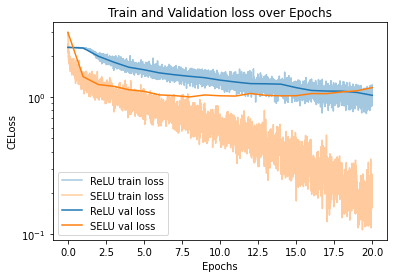

In [10]:
plt.figure()
plt.plot(np.asarray(range(len(rtl))) / len(trainloader), rtl, alpha=0.4, label="ReLU train loss")
plt.plot(np.asarray(range(len(stl))) / len(trainloader), stl, alpha=0.4, label="SELU train loss")
plt.plot(range(len(rvl)), rvl, color="C0", label="ReLU val loss")
plt.plot(range(len(svl)), svl, color="C1", label="SELU val loss")
plt.title("Train and Validation loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("CELoss")
plt.yscale("log")
plt.legend()
plt.show()

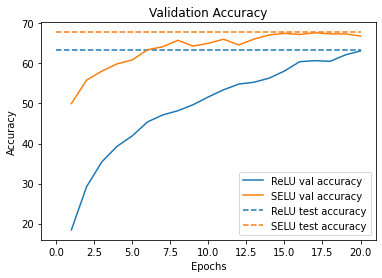

In [11]:
plt.figure()
plt.plot(range(1, len(raccs)+1), [a*100 for a in raccs], label="ReLU val accuracy")
plt.hlines(y=racc*100, xmin=0, xmax=len(raccs), colors="C0", linestyles="dashed", label="ReLU test accuracy")
plt.plot(range(1, len(saccs)+1), [a*100 for a in saccs], label="SELU val accuracy")
plt.hlines(y=sacc*100, xmin=0, xmax=len(saccs), colors="C1", linestyles="dashed", label="SELU test accuracy")
plt.title("Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.legend()
plt.show()